In [1]:
# import packages
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report

In [2]:
# load dataset
url = 'https://raw.githubusercontent.com/yinyin0916/DSGA1001-Data-Analysis-Project/main/movieReplicationSet.csv'
df = pd.read_csv(url)
movie_ratings = df.iloc[:,:400]

In [3]:
df.iloc[:,401:]

,I enjoy rollercoasters,Have you ever bungee-jumped?,I enjoy impulse shopping,I sometimes go out on weeknights even if I have work to do,I enjoy doing things without too much planning,Have you ever been rock climbing?,I enjoy being in large loud crowds like the Times Square Ball Drop on New Years Eve,I enjoy going to large music or dance festivals,I enjoy watching horror movies,No risk - No fun,...,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching,Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,5.0,2.0,5.0,1.0,2.0,3.0,1.0,4.0,1.0,3.0,...,1.0,6.0,2.0,5.0,5.0,5.0,1.0,1.0,0,1
1,5.0,2.0,4.0,2.0,1.0,1.0,2.0,4.0,1.0,3.0,...,3.0,1.0,1.0,6.0,5.0,3.0,2.0,1.0,0,0
2,4.0,1.0,2.0,2.0,2.0,1.0,3.0,4.0,1.0,3.0,...,5.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,1,0
3,5.0,2.0,5.0,4.0,2.0,4.0,4.0,5.0,4.0,1.0,...,3.0,1.0,1.0,4.0,5.0,3.0,1.0,1.0,0,1
4,1.0,3.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,4.0,...,2.0,3.0,2.0,5.0,6.0,4.0,4.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,4.0,2.0,5.0,2.0,1.0,3.0,2.0,5.0,1.0,3.0,...,3.0,4.0,3.0,5.0,5.0,4.0,4.0,1.0,0,0
1093,5.0,2.0,5.0,4.0,1.0,4.0,4.0,5.0,5.0,4.0,...,5.0,3.0,5.0,5.0,5.0,6.0,5.0,1.0,0,0
1094,5.0,2.0,2.0,3.0,1.0,4.0,1.0,4.0,1.0,2.0,...,6.0,3.0,1.0,6.0,6.0,4.0,2.0,1.0,0,0
1095,4.0,2.0,5.0,2.0,5.0,1.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,4.0,3.0,3.0,1.0,1.0,0,1


In [4]:
df.iloc[:,400:].isna().sum()

I enjoy driving fast                                                        3
I enjoy rollercoasters                                                      4
Have you ever bungee-jumped?                                                5
I enjoy impulse shopping                                                    6
I sometimes go out on weeknights even if I have work to do                  3
                                                                           ..
Movies change my position on social economic or political issues           20
When watching movies things get so intense that I have to stop watching    18
Gender identity (1 = female; 2 = male; 3 = self-described)                 24
Are you an only child? (1: Yes; 0: No; -1: Did not respond)                 0
Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)          0
Length: 77, dtype: int64

In [5]:
def blend_impute(df):
    # Make a copy of the DataFrame to avoid changing the original data
    imputed_df = df.copy()

    # Calculate the mean of each column and row, skipping NaN values
    column_means = df.mean(axis=0).fillna(0)
    row_means = df.mean(axis=1).fillna(0)

    # Iterate over each element in the DataFrame
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            # Check if the element is NaN
            if pd.isna(df.iloc[row, col]):
                # Calculate blended value (50/50) of the row mean and column mean
                if (column_means[col] == 0):
                  blended_value = row_means[row]
                elif (row_means[row] == 0):
                  blended_value = column_means[col]
                else:
                  blended_value = (column_means[col] + row_means[row]) / 2
                # Assign the blended value to the NaN element
                imputed_df.iloc[row, col] = blended_value

    return imputed_df

In [6]:
# impute movie ratings
imputed_x = blend_impute(df.iloc[:,:400])
imputed_x

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,X-Men 2 (2003),The Usual Suspects (1995),The Mask (1994),Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989)
0,2.447086,2.381992,4.000000,2.725235,3.000000,2.670257,2.554121,2.821232,2.619604,2.827211,...,2.828460,2.921947,2.650951,4.000000,0.500000,2.510773,2.519156,2.572578,2.428806,2.540410
1,2.439294,2.374200,1.500000,2.717443,2.752945,2.662464,2.546329,2.813440,2.611812,2.819419,...,2.820668,2.914154,2.643159,2.673112,4.000000,2.502981,2.511364,2.564786,2.421013,2.532618
2,2.733065,2.667971,3.234118,3.011214,3.046716,2.956236,2.840100,3.107211,2.905583,3.113190,...,3.114439,3.207926,2.936930,2.966883,3.500000,2.796752,2.805135,2.858557,2.714784,2.826389
3,2.282975,2.217880,2.000000,2.561123,3.000000,2.506145,2.390009,2.657120,2.455492,4.000000,...,2.664348,3.000000,2.486840,2.516793,2.500000,2.346661,2.355044,2.408466,2.264694,2.376299
4,2.209132,2.144038,3.500000,2.487281,0.500000,2.432303,0.500000,1.000000,2.381650,0.000000,...,2.500000,2.683993,3.000000,2.442950,2.769704,2.272819,2.281202,1.500000,2.190852,2.302456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,2.675658,2.610563,3.176711,2.953806,3.500000,2.898828,2.782692,3.049803,2.848175,3.055782,...,3.057031,3.150518,2.879523,2.909476,4.000000,2.739344,2.747727,2.801149,2.657377,2.768981
1093,3.000000,4.000000,3.413546,3.190641,4.000000,4.000000,2.500000,3.286638,3.500000,3.500000,...,4.000000,3.387353,4.000000,3.500000,3.500000,4.000000,3.500000,4.000000,4.000000,4.000000
1094,2.641923,2.576828,3.142976,2.920071,2.955574,2.865093,2.748957,3.500000,2.814440,3.022047,...,3.023296,3.116783,2.845788,2.875741,4.000000,2.705609,2.713992,2.767414,2.623642,2.735247
1095,2.770970,2.705876,3.272023,3.049119,3.084621,2.994141,2.878005,3.145116,2.943488,3.151095,...,3.152344,3.245831,2.974835,3.004788,2.500000,2.834657,2.843040,2.896462,2.752690,2.864294


### 1) For each of the 400 movies, use a simple linear regression model to predict the ratings. Use the ratings of the *other* 399 movies in the dataset to predict the ratings of each movie (that means you’ll have to build 399 models for each of the 400 movies). For each of the 400 movies, find the movie that predicts ratings the best. Then report the average COD of those 400 simple linear regression models. Please include a histogram of these 400 COD values and a table with the 10 movies that are most easily predicted from the ratings of a single other movie and the 10 movies that are hardest to predict from the ratings of a single other movie (and their associated COD values, as well as which movie ratings are the best predictor, so this table should have 3 columns).

In [7]:
# for each of 400 movies, find movie that predicts ratings the best.
avg_CODs = []
predicted_movie = []
best_feature_movie = []
best_predictor_COD = []
# loop through each y
for i in range(400):
  CODs = []
  max_COD = 0
  best_model = None
  best_movie = ''
  # loop through each feature
  for j in range(400):
    if i == j:
      continue
    else:
      # generate feature X
      X = imputed_x.iloc[:,j:j+1]
      # generate true prediction y
      y = imputed_x.iloc[:,i:i+1]
      # create model and fit dataset
      model_lr = LinearRegression().fit(X, y)
      # predict y based on given X, find r^2
      COD = r2_score(y,model_lr.predict(X))
      CODs.append(COD)
      # find if it's max COD
      if COD > max_COD:
        # if it is, update max_COD, best_model and best predictor movie
        max_COD = COD
        best_model = model_lr
        best_movie = X.columns.values[0]
  # after each prediction, calculate average CODs
  avg_CODs.append(sum(CODs)/len(CODs))
  # add predicted movie
  predicted_movie.append(y.columns.values[0])
  # add best predictor movie
  best_feature_movie.append(best_movie)
  # add best predictor's COD
  best_predictor_COD.append(max_COD)
  print(f'movie that predicts "{y.columns.values[0]}" ratings the best:', best_movie)
  print('average COD', sum(CODs)/len(CODs))

movie that predicts "The Life of David Gale (2003)" ratings the best: The King of Marvin Gardens (1972)
average COD 0.27772250384675334
movie that predicts "Wing Commander (1999)" ratings the best: From Hell (2001)
average COD 0.2679968855741639
movie that predicts "Django Unchained (2012)" ratings the best: The Life of David Gale (2003)
average COD 0.11367972288582694
movie that predicts "Alien (1979)" ratings the best: Aliens (1986)
average COD 0.1389255526747208
movie that predicts "Indiana Jones and the Last Crusade (1989)" ratings the best: Indiana Jones and the Temple of Doom (1984)
average COD 0.1158672973752565
movie that predicts "Snatch (2000)" ratings the best: Slackers (2002)
average COD 0.21832619525813032
movie that predicts "Rambo: First Blood Part II (1985)" ratings the best: Pieces of April (2003)
average COD 0.14365823495980493
movie that predicts "Fargo (1996)" ratings the best: Brazil (1985)
average COD 0.14223725195216966
movie that predicts "Let the Right One In (

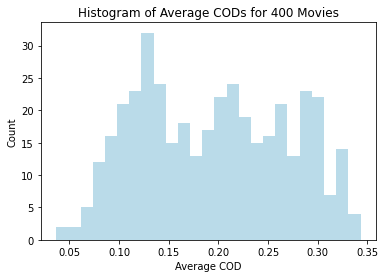

In [8]:
plt.hist(avg_CODs, density=False, bins = 25, color = '#badbe9')
plt.title('Histogram of Average CODs for 400 Movies')
plt.xlabel('Average COD')
plt.ylabel('Count')
plt.show()

In [9]:
sum(avg_CODs)/len(avg_CODs)

0.1952543657742067

In [10]:
# 10 movies that are most easily predicted from the ratings of a single other movie and the 10 movies that are hardest to predict from the ratings of a single other movie
COD_df = pd.DataFrame({'Average COD': avg_CODs, 'Predicted Movie': predicted_movie, 'Best Predicts of Predicted Movie': best_feature_movie, 'Best COD': best_predictor_COD}).sort_values(by = 'Average COD')
best_worst_10 = pd.concat([COD_df.head(10), COD_df.tail(10)])
pd.set_option('display.max_columns', 20)
best_worst_10[['Average COD', 'Predicted Movie', 'Best Predicts of Predicted Movie']]

,Average COD,Predicted Movie,Best Predicts of Predicted Movie
80,0.036659,Avatar (2009),Bad Boys (1995)
84,0.042864,The Conjuring (2013),The Exorcist (1973)
95,0.052908,Interstellar (2014),Torque (2004)
9,0.058093,Black Swan (2010),Sorority Boys (2002)
190,0.065031,The Cabin in the Woods (2012),The Evil Dead (1981)
57,0.065471,Shrek 2 (2004),Shrek (2001)
186,0.069699,The Avengers (2012),Captain America: Civil War (2016)
55,0.071286,Clueless (1995),Escape from LA (1996)
75,0.071967,Pirates of the Caribbean: Dead Man's Chest (2006),Pirates of the Caribbean: At World's End (2007)
87,0.075677,Shrek (2001),Shrek 2 (2004)


### 2) For the 10 movies that are best and least well predicted from the ratings of a single other movie (so 20 in total), build multiple regression models that include gender identity (column 475), sibship status (column 476) and social viewing preferences (column 477) as additional predictors (in addition to the best predicting movie from question 1). Comment on how R^2 has changed relative to the answers in question 1. Please include a figure with a scatterplot where the old COD (for the simple linear regression models from the previous question) is on the x-axis and the new R^2 (for the new multiple regression models) is on the y-axis.

In [11]:
# 10 movies that are best and least well predicted from ratings of a single other movie
best_worst_10

,Average COD,Predicted Movie,Best Predicts of Predicted Movie,Best COD
80,0.036659,Avatar (2009),Bad Boys (1995),0.079484
84,0.042864,The Conjuring (2013),The Exorcist (1973),0.198484
95,0.052908,Interstellar (2014),Torque (2004),0.111184
9,0.058093,Black Swan (2010),Sorority Boys (2002),0.116970
190,0.065031,The Cabin in the Woods (2012),The Evil Dead (1981),0.143925
57,0.065471,Shrek 2 (2004),Shrek (2001),0.451027
186,0.069699,The Avengers (2012),Captain America: Civil War (2016),0.272223
55,0.071286,Clueless (1995),Escape from LA (1996),0.141324
75,0.071967,Pirates of the Caribbean: Dead Man's Chest (2006),Pirates of the Caribbean: At World's End (2007),0.367213
87,0.075677,Shrek (2001),Shrek 2 (2004),0.451027


In [12]:
predicted_movie = list(best_worst_10['Predicted Movie'])
predictor_movie = list(best_worst_10['Best Predicts of Predicted Movie'])

In [13]:
# add gender, sibship, social viewing preference as additional predictors, drop rows with nan gender/sibship status/social viewing preferences
features_q2 = pd.concat([imputed_x, df.iloc[:,474:]], axis = 1).dropna(subset = df.columns[474:])
features_q2

,The Life of David Gale (2003),Wing Commander (1999),Django Unchained (2012),Alien (1979),Indiana Jones and the Last Crusade (1989),Snatch (2000),Rambo: First Blood Part II (1985),Fargo (1996),Let the Right One In (2008),Black Swan (2010),...,Jaws (1975),Harry Potter and the Chamber of Secrets (2002),Patton (1970),Anaconda (1997),Twister (1996),MacArthur (1977),Look Who's Talking (1989),Gender identity (1 = female; 2 = male; 3 = self-described),Are you an only child? (1: Yes; 0: No; -1: Did not respond),Movies are best enjoyed alone (1: Yes; 0: No; -1: Did not respond)
0,2.447086,2.381992,4.000000,2.725235,3.000000,2.670257,2.554121,2.821232,2.619604,2.827211,...,4.000000,0.500000,2.510773,2.519156,2.572578,2.428806,2.540410,1.0,0,1
1,2.439294,2.374200,1.500000,2.717443,2.752945,2.662464,2.546329,2.813440,2.611812,2.819419,...,2.673112,4.000000,2.502981,2.511364,2.564786,2.421013,2.532618,1.0,0,0
2,2.733065,2.667971,3.234118,3.011214,3.046716,2.956236,2.840100,3.107211,2.905583,3.113190,...,2.966883,3.500000,2.796752,2.805135,2.858557,2.714784,2.826389,1.0,1,0
3,2.282975,2.217880,2.000000,2.561123,3.000000,2.506145,2.390009,2.657120,2.455492,4.000000,...,2.516793,2.500000,2.346661,2.355044,2.408466,2.264694,2.376299,1.0,0,1
4,2.209132,2.144038,3.500000,2.487281,0.500000,2.432303,0.500000,1.000000,2.381650,0.000000,...,2.442950,2.769704,2.272819,2.281202,1.500000,2.190852,2.302456,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,2.675658,2.610563,3.176711,2.953806,3.500000,2.898828,2.782692,3.049803,2.848175,3.055782,...,2.909476,4.000000,2.739344,2.747727,2.801149,2.657377,2.768981,1.0,0,0
1093,3.000000,4.000000,3.413546,3.190641,4.000000,4.000000,2.500000,3.286638,3.500000,3.500000,...,3.500000,3.500000,4.000000,3.500000,4.000000,4.000000,4.000000,1.0,0,0
1094,2.641923,2.576828,3.142976,2.920071,2.955574,2.865093,2.748957,3.500000,2.814440,3.022047,...,2.875741,4.000000,2.705609,2.713992,2.767414,2.623642,2.735247,1.0,0,0
1095,2.770970,2.705876,3.272023,3.049119,3.084621,2.994141,2.878005,3.145116,2.943488,3.151095,...,3.004788,2.500000,2.834657,2.843040,2.896462,2.752690,2.864294,1.0,0,1


In [14]:
# find the best CODs with q1's predicted movie and best predictor movie + 3 more features
avg_CODs_q2 = []
best_CODs_q2 = []
for i in range(20):
    CODs = []
    for j in range(400):
        y_name = predicted_movie[i]
        x_name = features_q2.columns[j]
        if x_name == y_name:
            continue
        else:
            # generate feature X
            X_q2 = pd.concat([features_q2.iloc[:,j:j+1], features_q2.iloc[:,-3:]], axis = 1).to_numpy()
            # generate true prediction y
            y_q2 = features_q2[y_name]
            # create model and fit dataset
            model_lr = LinearRegression().fit(X_q2, y_q2)
            # predict y based on given X, find r^2
            COD = r2_score(y_q2,model_lr.predict(X_q2))
            CODs.append(COD)
            if x_name == best_worst_10[best_worst_10['Predicted Movie'] == y_name]['Best Predicts of Predicted Movie'].values[0]:
                best_CODs_q2.append(COD)
    avg_CODs_q2.append(sum(CODs)/len(CODs))

In [15]:
(best_worst_10['Best COD'] <= best_CODs_q2).sum()

12

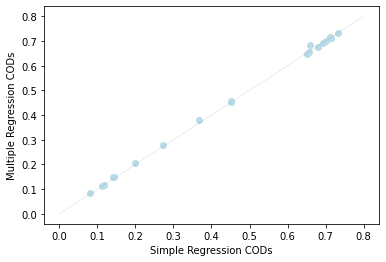

In [16]:
plt.scatter(best_worst_10['Best COD'], best_CODs_q2, color = '#badbe9')
plt.ylabel('Multiple Regression CODs')
plt.xlabel('Simple Regression CODs')
plt.plot([0, 0.8], [0, 0.8], color = 'black', linewidth = 0.1, linestyle = 'dashed');

In [17]:
# plt.scatter(best_worst_10['Average COD'], avg_CODs_q2, color = '#badbe9')
# plt.ylabel('Multiple Regression Average CODs')
# plt.xlabel('Simple Regression Average CODs')
# plt.plot([0, 0.8], [0, 0.8], color = 'black', linewidth = 0.1, linestyle = 'dashed');

### 3) Pick 30 movies in the middle of the COD range, as identified by question 1 (that were not used in question 2). Now build a regularized regression model with the ratings from 10 other movies (picked randomly, or deliberately by you) as an input. Please use ridge regression, and make sure to do suitable hyperparameter tuning. Also make sure to report the RMSE for each of these 30 movies in a table, after doing an 80/20 train/test split. Comment on the hyperparameters you use and betas you find by doing so.

In [18]:
middle30 = COD_df.sort_values(by = 'Average COD').reset_index().iloc[185:215].reset_index().drop(columns = 'level_0')
middle30

,index,Average COD,Predicted Movie,Best Predicts of Predicted Movie,Best COD
0,94,0.185444,The Thing (1982),Sexy Beast (2000),0.376664
1,88,0.186469,12 Monkeys (1995),Change of Habit (1969),0.401817
2,226,0.188566,Bad Boys (1995),Bad Boys 2 (2003),0.485797
3,130,0.188870,Armageddon (1998),Billy Jack (1971),0.365705
4,339,0.188913,Bad Boys 2 (2003),Bad Boys (1995),0.485797
5,349,0.189486,The Mist (2007),The Lookout (2007),0.367543
6,374,0.190656,Braveheart (1995),Blow (2001),0.396611
7,23,0.190663,The Others (2001),Barbarella (1968),0.390036
8,193,0.191279,Baby Geniuses (1999),Sexy Beast (2000),0.395268
9,360,0.191292,One Flew Over the Cuckoo's Nest (1975),Miller's Crossing (1990),0.363390


In [19]:
# generate a list of 400 elements as indices
list_of_400 = list(range(400))

# Previously selected indices (185 to 213)
selected_indices = set(list(middle30['index']))

# Remaining indices
remaining_indices = set(range(400)) - selected_indices

# Randomly select 10 unique indices from the remaining ones
random_10 = random.sample(remaining_indices, 10)

random_10
#random_10 in report: [376, 115, 268, 113, 122, 357, 359, 149, 300, 290]

[289, 182, 197, 93, 236, 36, 107, 346, 190, 116]

In [20]:
# generate all ys
y_q3 = imputed_x.iloc[:, list(middle30['index'])]
# generate corresponding x
x_q3 = imputed_x.iloc[:, random_10]

In [21]:
alpha = []
beta = []
intercept = []
rmses = []
for i in range(30):
  X_train, X_test, y_train, y_test = train_test_split(x_q3.to_numpy(), y_q3.iloc[:,i].to_numpy(), test_size=0.2, random_state=42)
  RidgeRegression = Ridge()
  param_distributions = {'alpha': [i for i in range(0,150,1)]}
  ridge_regressor = RandomizedSearchCV(estimator = RidgeRegression, param_distributions = param_distributions, n_iter = 16, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
  ridge_regressor.fit(X_train,y_train)
  rmse = np.sqrt(np.mean((ridge_regressor.predict(X_test) - y_test) ** 2))
  best_model = ridge_regressor.best_estimator_
  alpha.append(ridge_regressor.best_estimator_)
  beta.append(best_model.coef_)
  intercept.append(best_model.intercept_)
  rmses.append(rmse)

In [22]:
df_ridge = pd.DataFrame({'Predicted Movie':y_q3.columns, 'rmse': rmses, 'alpha': alpha, 'beta': beta, 'intercept': intercept})
df_ridge.to_csv('ridge.csv')
df_ridge

,Predicted Movie,rmse,alpha,beta,intercept
0,The Thing (1982),0.354865,Ridge(alpha=49),"[0.08825797333049491, 0.06907739229612003, 0.1...",0.142649
1,12 Monkeys (1995),0.393400,Ridge(alpha=29),"[0.18010653535836468, 0.010709220147575266, 0....",0.583075
2,Bad Boys (1995),0.415425,Ridge(alpha=45),"[0.13559325279247875, 0.04268920120317021, 0.0...",0.689151
3,Armageddon (1998),0.404258,Ridge(alpha=41),"[0.07762833747618067, 0.030024056605667995, 0....",0.439915
4,Bad Boys 2 (2003),0.445274,Ridge(alpha=65),"[0.10823286443653009, 0.05555789415285461, 0.0...",0.615909
5,The Mist (2007),0.376660,Ridge(alpha=9),"[0.07603031521674308, 0.029405434627717893, 0....",0.189469
6,Braveheart (1995),0.394134,Ridge(alpha=18),"[0.12022833917339346, 0.033419329647135634, 0....",0.532487
7,The Others (2001),0.354198,Ridge(alpha=23),"[0.07614127231871196, 0.015263260879362034, -0...",0.462428
8,Baby Geniuses (1999),0.411281,Ridge(alpha=20),"[0.23481812972959343, 0.014291932761037235, 0....",-0.066304
9,One Flew Over the Cuckoo's Nest (1975),0.430684,Ridge(alpha=37),"[0.1202403305409966, 0.14846378861010975, 0.08...",0.667509


### 4) Repeat question 3) with LASSO regression. Again, make sure to comment on the hyperparameters you use and betas you find by doing so.

In [23]:
alpha = []
beta = []
intercept = []
rmses = []
for i in range(30):
  X_train, X_test, y_train, y_test = train_test_split(x_q3.to_numpy(), y_q3.iloc[:,i].to_numpy(), test_size=0.2, random_state=42)
  LassoRegression = Lasso()
  alphas = np.arange (0.0001, 1, 0.0005)
  param_distributions = {'alpha': alphas}
  LassoRegression = RandomizedSearchCV(estimator = LassoRegression, param_distributions = param_distributions, n_iter = 10000, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)
  LassoRegression.fit(X_train,y_train)
  rmse = np.sqrt(np.mean((LassoRegression.predict(X_test) - y_test) ** 2))
  best_model = LassoRegression.best_estimator_
  alpha.append(LassoRegression.best_estimator_)
  beta.append(best_model.coef_)
  intercept.append(best_model.intercept_)
  rmses.append(rmse)
  print("alpha:", LassoRegression.best_estimator_)
  print("beta:", best_model.coef_)
  print("intercept:", best_model.intercept_)
  print("rmse:", rmse)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0026)
beta: [ 0.05823674  0.0540546   0.12572163  0.00688372 -0.04507115  0.27350977
  0.07935736  0.27843282  0.02711459  0.1264711 ]
intercept: 0.04173323637400106
rmse: 0.3580197437278513


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0041)
beta: [ 0.19150048  0.          0.00566122 -0.          0.00410338  0.43428272
  0.0824438   0.04626866 -0.          0.08397232]
intercept: 0.6024671913102622
rmse: 0.40056363090449515


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0056)
beta: [ 0.15788932  0.0207767   0.04530858  0.04630346  0.23919271 -0.
  0.13505155  0.11230344  0.03155689  0.        ]
intercept: 0.6997843340907974
rmse: 0.4170798123077297


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.004600000000000001)
beta: [ 0.02889266  0.          0.1364374   0.00479484  0.          0.09258265
  0.          0.17749371 -0.          0.45233521]
intercept: 0.39564959853565584
rmse: 0.4122205428944708


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.004600000000000001)
beta: [0.11141683 0.02501474 0.03537096 0.00711401 0.15979646 0.04478582
 0.09530829 0.13200104 0.01571024 0.24125701]
intercept: 0.5316836307192974
rmse: 0.4515563681596825


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0031)
beta: [ 0.05697224  0.01315989  0.          0.00506086 -0.          0.11325845
  0.0821574   0.37889754  0.02443943  0.24928022]
intercept: 0.22349002396461692
rmse: 0.3752305938826097


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0036)
beta: [ 0.09492943  0.00956905  0.0546157   0.          0.09280867 -0.
 -0.          0.49391293  0.02879182  0.10730526]
intercept: 0.5225564275987824
rmse: 0.39795549479650744


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0071)
beta: [ 0.03777218  0.         -0.          0.00495627  0.          0.37705401
  0.05427261  0.35650042  0.01623389  0.01441904]
intercept: 0.5570170646355117
rmse: 0.3539365925584182


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0056)
beta: [0.24979257 0.         0.         0.03638699 0.05361199 0.26359402
 0.0700762  0.00784604 0.         0.27493541]
intercept: 0.011299518575696776
rmse: 0.41146132056966817


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0041)
beta: [0.12887456 0.16481666 0.07691656 0.         0.02718021 0.
 0.17200271 0.25093079 0.00762422 0.05397689]
intercept: 0.6332896688590566
rmse: 0.4385439868814937


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0041)
beta: [0.18035596 0.0530966  0.07125749 0.02452046 0.15839635 0.08303768
 0.         0.         0.03245903 0.36745213]
intercept: 0.051728556640999734
rmse: 0.35825858004791206


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0036)
beta: [ 2.25428918e-01  1.24460957e-02 -0.00000000e+00  2.33246678e-04
  1.83660417e-01  2.70693713e-02  2.93851419e-02  2.63555819e-01
  2.60121551e-02  1.83569092e-01]
intercept: 0.3957858212871641
rmse: 0.31278953700385925


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0041)
beta: [ 0.07746921 -0.02984232  0.14154936  0.02284998  0.03836284  0.
  0.          0.5310421   0.08864408  0.02969891]
intercept: 0.4266980746736504
rmse: 0.43304745804338335


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.004600000000000001)
beta: [0.         0.         0.05894157 0.01737426 0.04645532 0.29534226
 0.09681936 0.07443625 0.         0.20702367]
intercept: 0.42178017167442894
rmse: 0.4151636641567899


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0081)
beta: [ 0.11829884  0.11267111  0.09976648  0.          0.22304622 -0.
  0.06568176  0.26597555  0.01376686  0.11127671]
intercept: 0.1794802040547414
rmse: 0.5319616641359808


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0056)
beta: [ 0.14671443  0.          0.08463415 -0.00333884  0.04472481  0.07906344
  0.13003996  0.07166906  0.00815644  0.29379976]
intercept: 0.7651533285311416
rmse: 0.4122114197418845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0011)
beta: [ 0.08820008  0.10751726  0.19288003  0.0352788   0.06490601 -0.04101859
  0.07762039  0.26123817  0.          0.20233269]
intercept: 0.07004225846042367
rmse: 0.3115328340530032


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0051)
beta: [0.26663871 0.00392854 0.05778853 0.04002233 0.16300143 0.
 0.13480536 0.19226538 0.01735532 0.02863892]
intercept: 0.2137967468565387
rmse: 0.4214332628079337


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0051)
beta: [0.22348083 0.         0.04063469 0.01916048 0.12241346 0.08854873
 0.         0.         0.01925008 0.37373757]
intercept: 0.21898762777132363
rmse: 0.32594436401007654


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0056)
beta: [ 0.          0.02873607  0.02616486  0.02372306  0.13951398  0.32238578
  0.          0.2949083  -0.01397861  0.11150015]
intercept: 0.340491568839989
rmse: 0.24647471055156625


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0036)
beta: [ 0.29371966  0.01937261  0.02808716  0.02268399  0.09553799  0.13104742
  0.11489709  0.08117229 -0.01134254  0.29841693]
intercept: 0.24178563210885295
rmse: 0.49828186307972844


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0071)
beta: [ 0.01517354  0.00519261  0.          0.03455128  0.          0.24808976
  0.0802583   0.01429477 -0.          0.43442457]
intercept: 0.40773111338555923
rmse: 0.32760571806542926


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0021)
beta: [1.61848568e-01 1.17617216e-01 1.73731930e-02 0.00000000e+00
 1.31821996e-01 7.63692989e-02 2.60392413e-01 8.21980084e-05
 3.22924339e-02 1.03703831e-01]
intercept: 0.5435322620813254
rmse: 0.38350593965969304


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.006600000000000001)
beta: [ 0.24462185 -0.          0.01592367  0.0019176   0.          0.20653483
 -0.          0.12661624  0.01599186  0.26052492]
intercept: 0.4048671453817736
rmse: 0.32467921397923805


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0041)
beta: [0.13071891 0.02893924 0.07071729 0.         0.04272849 0.15627437
 0.10728453 0.1847896  0.         0.15986538]
intercept: 0.6443303339020803
rmse: 0.2894175517893453


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0051)
beta: [0.20541929 0.         0.15680969 0.01121264 0.12295611 0.16074298
 0.06073479 0.15702465 0.         0.        ]
intercept: 0.44355210997339034
rmse: 0.4472241511119494


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0036)
beta: [0.30105337 0.04867252 0.10712336 0.03498001 0.18215131 0.
 0.00119336 0.28466353 0.04664921 0.        ]
intercept: -0.1111673620972935
rmse: 0.35750647366564015


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0036)
beta: [ 0.11836624  0.03734023  0.02591415  0.00568692  0.10461817 -0.
  0.12801158  0.17377886  0.04310814  0.23391305]
intercept: 0.22287198881995618
rmse: 0.3576354653315489


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0091)
beta: [ 8.14454415e-05  0.00000000e+00  8.71196115e-02  0.00000000e+00
 -0.00000000e+00  6.71205061e-02  1.32536871e-01  4.74717908e-02
 -0.00000000e+00  6.30552990e-01]
intercept: 0.27081009765932773
rmse: 0.3919698407661184


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2000 is smaller than n_iter=10000. Running 2000 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


alpha: Lasso(alpha=0.0031)
beta: [ 0.17939574 -0.          0.08186397  0.01135376  0.04900199  0.01193192
  0.14355434  0.33115158 -0.02256649  0.22923422]
intercept: -0.07979000816814441
rmse: 0.37995580516073635


In [24]:
df_lasso = pd.DataFrame({'Predicted Movie':y_q3.columns, 'rmse': rmses, 'alpha': alpha, 'beta': beta, 'intercept': intercept})
df_lasso.to_csv('lasso.csv')
df_lasso

,Predicted Movie,rmse,alpha,beta,intercept
0,The Thing (1982),0.358020,Lasso(alpha=0.0026),"[0.05823674057287517, 0.05405460150217933, 0.1...",0.041733
1,12 Monkeys (1995),0.400564,Lasso(alpha=0.0041),"[0.19150047586307004, 0.0, 0.00566121976024473...",0.602467
2,Bad Boys (1995),0.417080,Lasso(alpha=0.0056),"[0.157889323499399, 0.02077669851330078, 0.045...",0.699784
3,Armageddon (1998),0.412221,Lasso(alpha=0.004600000000000001),"[0.02889265521777726, 0.0, 0.13643739918903489...",0.395650
4,Bad Boys 2 (2003),0.451556,Lasso(alpha=0.004600000000000001),"[0.1114168265967545, 0.025014743311734533, 0.0...",0.531684
5,The Mist (2007),0.375231,Lasso(alpha=0.0031),"[0.05697224088892016, 0.01315988862908287, 0.0...",0.223490
6,Braveheart (1995),0.397955,Lasso(alpha=0.0036),"[0.09492942977230806, 0.009569054519395848, 0....",0.522556
7,The Others (2001),0.353937,Lasso(alpha=0.0071),"[0.03777217825679792, 0.0, -0.0, 0.00495626913...",0.557017
8,Baby Geniuses (1999),0.411461,Lasso(alpha=0.0056),"[0.2497925657081217, 0.0, 0.0, 0.0363869911846...",0.011300
9,One Flew Over the Cuckoo's Nest (1975),0.438544,Lasso(alpha=0.0041),"[0.12887456219353546, 0.16481666241500392, 0.0...",0.633290


### 5) Compute the average movie enjoyment for each user (using only real, non-imputed data). Use these averages as the predictor variable X in a logistic regression model. Sort the movies order of increasing rating (also using only real, non-imputed data). Now pick the 4 movies in the middle of the score range as your target movie. For each of them, do a media split (now using the imputed data) of ratings to code movies above the median rating with the Y label 1 (= enjoyed) and movies below the median with the label 0 (= not enjoyed). For each of these movies, build a logistic regression model (using X to predict Y), show figures with the outcomes and report the betas as well as the AUC values. Comment on the quality of your models. Make sure to use cross-validation methods to avoid overfitting.

In [25]:
each_user_avg = movie_ratings.mean(axis = 1).fillna(0)
middle_4 = movie_ratings.mean(axis = 0).sort_values()[198:202].index
middle_4_ratings = movie_ratings.mean(axis = 0).sort_values()[198:202]

In [26]:
ratings = []
for i in middle_4:
  median_i = imputed_x[i].median()
  ratings.append(imputed_x[i].apply(lambda x: 1 if x > median_i else 0))

In [27]:
## K-Fold Cross Validation
def k_fold(X,y):
  kfold = KFold(n_splits=10)
  model = LogisticRegression()
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
  return scores

In [28]:
for i in range(4):
  print(f'K Fold Cross Validation Score for {middle_4[i]}: ', k_fold(each_user_avg.values.reshape(-1,1), ratings[i].values.reshape(-1,1)).mean())

K Fold Cross Validation Score for Fahrenheit 9/11 (2004):  0.94348623853211


K Fold Cross Validation Score for Happy Gilmore (1996):  0.880483736447039
K Fold Cross Validation Score for Diamonds are Forever (1971):  0.9462051709758132
K Fold Cross Validation Score for Scream (1996):  0.8477314428690577


==============================================Fahrenheit 9/11 (2004)==============================================
==============================================Happy Gilmore (1996)==============================================


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


==============================================Diamonds are Forever (1971)==============================================
==============================================Scream (1996)==============================================


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


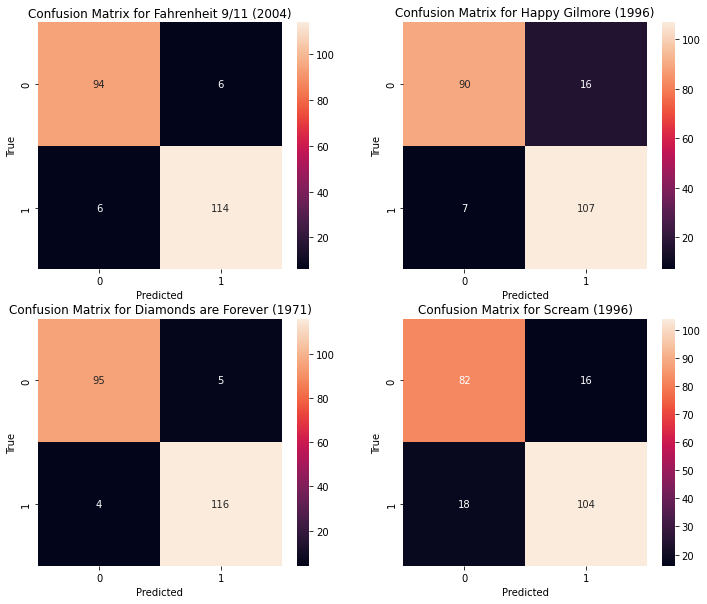

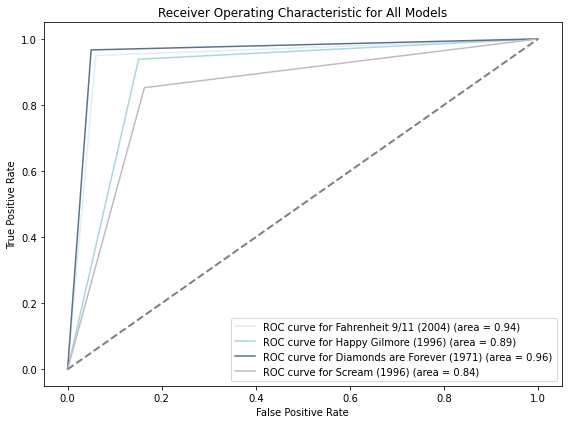

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
roc_fig, roc_ax = plt.subplots(figsize=(8, 6))

# Initialize variables to store ROC curve data
all_fpr = []
all_tpr = []
all_auc = []

for i in range(4):
    print(f"=============================================={middle_4[i]}==============================================")
    
    # Model fitting
    model = LogisticRegression()
    X = each_user_avg.values.reshape(-1, 1)
    y = ratings[i].values.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    
    # Prediction and Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i//2, i%2])
    axes[i//2, i%2].set_xlabel('Predicted')
    axes[i//2, i%2].set_ylabel('True')
    axes[i//2, i%2].set_title(f'Confusion Matrix for {middle_4[i]}')

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Store ROC curve data
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)
colors = ['#ddeff6','#a8d8e2', '#5b7288', '#c5b8bf']
# Plot ROC Curve for all models
for i in range(4):
    roc_ax.plot(all_fpr[i], all_tpr[i], label=f'ROC curve for {middle_4[i]} (area = %0.2f)' % all_auc[i], color = colors[i])

roc_ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
roc_ax.set_xlabel('False Positive Rate')
roc_ax.set_ylabel('True Positive Rate')
roc_ax.set_title('Receiver Operating Characteristic for All Models')
roc_ax.legend(loc="lower right")

# Show plots
plt.tight_layout()
plt.show()


### Extra Credit: Use machine learning methods of your choice to tell us something interesting and true about the movies in this dataset that is not already covered by the questions above [for an additional 5% of the grade score].

We are interested in which movie is best predicted by each of movie experience ratings from columns 465 - 474. We will also find out the movie experience ratings which predict movie ratings the best.  
In order to do so, we will first drop nan in self-reported movie experience ratings. We decide to drop nan because 1. It is hard for us to correctly impute these ratings, especially when we impute misleading data, it will worsen the model's prediction. 2. There are only 50 rows being dropped, and our training dataset is still large if we drop.

In [30]:
df.iloc[:,464:474]

,I have cried during a movie,I have trouble following the story of a movie,I have trouble remembering the story of a movie a couple of days after seeing it,When watching a movie I cheer or shout or talk or curse at the screen,When watching a movie I feel like the things on the screen are happening to me,As a movie unfolds I start to have problems keeping track of events that happened earlier,"The emotions on the screen ""rub off"" on me - for instance if something sad is happening I get sad or if something frightening is happening I get scared",When watching a movie I get completely immersed in the alternative reality of the film,Movies change my position on social economic or political issues,When watching movies things get so intense that I have to stop watching
0,3.0,4.0,1.0,1.0,6.0,2.0,5.0,5.0,5.0,1.0
1,5.0,3.0,1.0,3.0,1.0,1.0,6.0,5.0,3.0,2.0
2,4.0,3.0,1.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0
3,4.0,1.0,1.0,3.0,1.0,1.0,4.0,5.0,3.0,1.0
4,4.0,3.0,4.0,2.0,3.0,2.0,5.0,6.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...
1092,5.0,4.0,3.0,3.0,4.0,3.0,5.0,5.0,4.0,4.0
1093,5.0,4.0,5.0,5.0,3.0,5.0,5.0,5.0,6.0,5.0
1094,4.0,2.0,3.0,6.0,3.0,1.0,6.0,6.0,4.0,2.0
1095,5.0,5.0,3.0,1.0,1.0,1.0,4.0,3.0,3.0,1.0


In [31]:
df.iloc[:,:400].columns

Index(['The Life of David Gale (2003)', 'Wing Commander (1999)',
       'Django Unchained (2012)', 'Alien (1979)',
       'Indiana Jones and the Last Crusade (1989)', 'Snatch (2000)',
       'Rambo: First Blood Part II (1985)', 'Fargo (1996)',
       'Let the Right One In (2008)', 'Black Swan (2010)',
       ...
       'X-Men 2 (2003)', 'The Usual Suspects (1995)', 'The Mask (1994)',
       'Jaws (1975)', 'Harry Potter and the Chamber of Secrets (2002)',
       'Patton (1970)', 'Anaconda (1997)', 'Twister (1996)',
       'MacArthur (1977)', 'Look Who's Talking (1989)'],
      dtype='object', length=400)

In [32]:
franchises = ['Star Wars', 'Harry Potter','The Matrix','Indiana Jones', 'Jurassic Park', 'Pirates of the Caribbean', 'Toy Story', 'Batman']
franchises_dict = {i:[] for i in franchises}
for i in franchises:
  for j in list(movie_ratings.columns):
    if i in j:
      franchises_dict[i].append(j)

In [33]:
def COD_for_franchises(franchise):
    movie_x = []
    average_COD_series = []
    average_COD_nonseries = []
    for i in franchises_dict[franchise]:
        movie_x.append(i)
        y = imputed_x[i]
        CODs_series = []
        CODs_nonseries = []
        for j in franchises_dict[franchise]:
            if i == j:
                continue
            else:
                model = LinearRegression()
                X = imputed_x[[j]]
                model.fit(X,y)
                y_predict = model.predict(X)
                COD = r2_score(y,y_predict)
                CODs_series.append(COD)
        average_COD_series.append(sum(CODs_series) / len(CODs_series))

        for k in imputed_x.columns:
            if k in franchises_dict[franchise]:
                continue
            else:
                model = LinearRegression()
                X = imputed_x[[k]]
                model.fit(X,y)
                y_predict = model.predict(X)
                COD = r2_score(y,y_predict)
                CODs_nonseries.append(COD)
        average_COD_nonseries.append(sum(CODs_nonseries) / len(CODs_nonseries))
    return pd.DataFrame({'Predicted Movie': movie_x, 'Average COD by franchise': average_COD_series, 'Average COD by non-franchise': average_COD_nonseries })

In [34]:
df = COD_for_franchises('Star Wars')
for i in list(franchises_dict.keys()):
    if i == 'Star Wars': continue
    else:
        df = pd.concat([df,COD_for_franchises(i)], axis = 0)

In [35]:
df

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Star Wars: Episode IV - A New Hope (1977),0.287799,0.105892
1,Star Wars: Episode II - Attack of the Clones (...,0.202247,0.080636
2,Star Wars: Episode V - The Empire Strikes Back...,0.317275,0.143535
3,Star Wars: Episode 1 - The Phantom Menace (1999),0.224141,0.119022
4,Star Wars: Episode VII - The Force Awakens (2015),0.286169,0.127864
5,Star Wars: Episode VI - The Return of the Jedi...,0.343467,0.150323
0,Harry Potter and the Sorcerer's Stone (2001),0.489660,0.121050
1,Harry Potter and the Deathly Hallows: Part 2 (...,0.451240,0.101479
2,Harry Potter and the Goblet of Fire (2005),0.475639,0.102527
3,Harry Potter and the Chamber of Secrets (2002),0.520020,0.121837


In [36]:
COD_for_franchises('Star Wars')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Star Wars: Episode IV - A New Hope (1977),0.287799,0.105892
1,Star Wars: Episode II - Attack of the Clones (...,0.202247,0.080636
2,Star Wars: Episode V - The Empire Strikes Back...,0.317275,0.143535
3,Star Wars: Episode 1 - The Phantom Menace (1999),0.224141,0.119022
4,Star Wars: Episode VII - The Force Awakens (2015),0.286169,0.127864
5,Star Wars: Episode VI - The Return of the Jedi...,0.343467,0.150323


In [37]:
COD_for_franchises('Harry Potter')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Harry Potter and the Sorcerer's Stone (2001),0.489660,0.121050
1,Harry Potter and the Deathly Hallows: Part 2 (...,0.451240,0.101479
2,Harry Potter and the Goblet of Fire (2005),0.475639,0.102527
3,Harry Potter and the Chamber of Secrets (2002),0.520020,0.121837


In [38]:
COD_for_franchises('The Matrix')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,The Matrix Revolutions (2003),0.269488,0.091391
1,The Matrix Reloaded (2003),0.290474,0.134116
2,The Matrix (1999),0.246539,0.141166


In [39]:
COD_for_franchises('Indiana Jones')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Indiana Jones and the Last Crusade (1989),0.277306,0.114644
1,Indiana Jones and the Temple of Doom (1984),0.273380,0.125582
2,Indiana Jones and the Raiders of the Lost Ark ...,0.221210,0.152579
3,Indiana Jones and the Kingdom of the Crystal S...,0.135923,0.106655


In [40]:
COD_for_franchises('Jurassic Park')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,The Lost World: Jurassic Park (1997),0.303064,0.117555
1,Jurassic Park III (2001),0.255836,0.092954
2,Jurassic Park (1993),0.249579,0.156544


In [41]:
COD_for_franchises('Pirates of the Caribbean')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Pirates of the Caribbean: Dead Man's Chest (2006),0.319626,0.070719
1,Pirates of the Caribbean: At World's End (2007),0.381044,0.126084
2,Pirates of the Caribbean: The Curse of the Bla...,0.333457,0.132567


In [42]:
COD_for_franchises('Toy Story')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Toy Story 2 (1999),0.457797,0.123603
1,Toy Story 3 (2010),0.445520,0.098338
2,Toy Story (1995),0.438409,0.131227


In [43]:
COD_for_franchises('Batman')

,Predicted Movie,Average COD by franchise,Average COD by non-franchise
0,Batman & Robin (1997),0.112526,0.097849
1,Batman (1989),0.154099,0.160186
2,Batman: The Dark Knight (2008),0.073812,0.107632
